# Multi-Resolution Image Blending from scratch

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:

from PIL import Image

In [3]:
img = Image.open('Julia.jpeg')
anansi_veles_img = img.resize((x//4 for x in img.size)) # downscale by 4

# Building a Gaussian Pyramid

In [4]:
from pyramid import pyramid, smoothing_kernel
from PIL import ImageFilter

kernel = ImageFilter.GaussianBlur(2)
# kernel = smoothing_kernel()
g = pyramid(anansi_veles_img, scale=5, kernel=kernel)
for x in g:
    print(x.size)
    # x.show()

(691, 884)
(345, 442)
(172, 221)
(86, 110)
(43, 55)


# Showing the effects of what smoothing an image does

In [5]:
from PIL import ImageChops, ImageFilter
kernel = ImageFilter.GaussianBlur(2)
g0 = anansi_veles_img
g1 = anansi_veles_img.filter(kernel)
# g1.show()
diff = ImageChops.difference(g0, g1)
# diff = ImageChops.subtract(g1, g0, 1.0, 150) #150 added here to help brighten the image
# diff.show()

# Building the laplcaian pyramid

In [6]:
from pyramid import laplacian
l = laplacian(anansi_veles_img, scale=5, kernel=kernel)
for im in l:
    print(im.size)
    # im.show()

(690, 884)
(344, 442)
(172, 220)
(86, 110)
(42, 54)


## Moment of truth!
Reconstructing the original image from the first laplacian, $l_0$ and the 2nd pyramid $g_1$

In [7]:
from pyramid import expand

g[1].show()
l[0].show()
anansi_veles_img.show()

original_image = ImageChops.add(l[0], expand(g[1]))
original_image.show()

# Multi-Resolution Image Blending

Showing what blending looks like with the matting equation (with and without laplacian pyramids)

In [8]:
from PIL import Image, ImageChops

A = Image.open('Hand.png').convert('RGB')
A = A.resize((x//4 for x in A.size))
A.show()

B = Image.open('Veles-Mask-Template.png').convert('RGB')
B = B.resize((x//4 for x in B.size))
B.show()

M = Image.open('Mask.png').convert('L')
M = M.resize((x//4 for x in M.size))
M.show()

## Using the naive approach
Using the matting approach

In [9]:
M = Image.open('Mask.png').convert('L')
M = M.resize((x//4 for x in M.size))

# the composite function uses the matting equation
result = ImageChops.composite(B, A, M)
result.show()

## Using Multi-Resolution Blending

In [10]:
from PIL import ImageFilter, Image
from pyramid import laplacian, laplacian0, pyramid

kernel = ImageFilter.GaussianBlur(2)

# Compute A's laplcaian pyramid
gaussian_A = pyramid(A, scale=5, kernel=kernel)
laplacian_A = laplacian0(gaussian_A, scale=5)
laplacian_A[0].show()
# gaussian_A[0].show()

# Compute B's laplcaian pyramid
gaussian_B = pyramid(B, scale=5, kernel=kernel)
laplacian_B = laplacian(B, scale=5, kernel=kernel)
laplacian_B[0].show()

# Compute M's gaussian pyramid
gaussian_M = pyramid(M, scale=5, kernel=kernel)
gaussian_M[0].show()

Scale 3
Scale 2
Scale 1
Scale 0


## Create the blended image

In [11]:
# The gaussian images `gaussian_M` has some images a single pixel large than the other laplacian images
# e.g at level 4, all images are (188, 252) - (188, 252) - (189, 252) with the gaussian being (189,252)
expected_sizes = [x.size for x in laplacian_A]
gaussian_M = [im.resize(sz, Image.ANTIALIAS) for sz,im in zip(expected_sizes, gaussian_M)]

In [12]:
result = []
for i in range(0, len(laplacian_A)):
    lbi = laplacian_B[i]
    lai = laplacian_A[i]
    gmi = gaussian_M[i]
    t = ImageChops.composite(lbi, lai, gmi)
    result.append(t)
result[0].show()

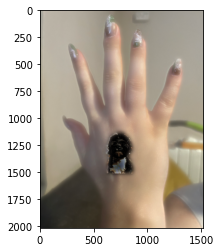

In [13]:
from pyramid import expand, reconstruct_laplacian
import numpy as np
import matplotlib.pyplot as plt
# blended_image = ImageChops.add(result[0], expand(gaussian_A[1]))
# blended_image.show()

# or using only the laplacian
blended_image = reconstruct_laplacian(result)
blended_image.show()
blended_image.save('blended_image_scratch.png')

img = np.array(blended_image, dtype=np.uint8)
plt.imshow(img)

In [14]:
# up2 = result[4].resize(result[3].size, Image.ANTIALIAS)
# up2.show()
# r = ImageChops.add(result[3], up2)
# r.show()

# bubbled = []
# scale = len(result)
# print(scale)
# up = result[-1]
# for i in (range(scale-1,0,-1)):
#     print(f"Scale {i}")
#     up = up.resize(result[i-1].size, Image.ANTIALIAS)
#     print(up.size)
#     print(result[i-1].size)
#     # li = ImageChops.subtract(gp[i], gExp)
#     up = ImageChops.add(result[i-1], up)
#     # up.show()
#     bubbled.append(up)

# [x.show() for x in result]


5
Scale 4
(188, 252)
(188, 252)
Scale 3
(378, 504)
(378, 504)
Scale 2
(756, 1008)
(756, 1008)
Scale 1
(1512, 2016)
(1512, 2016)
